## Still needs to be done:
- add geothermal gradient?
- add Q-Q plot
- add quantified GOF
- add warnings for wrong uploads


- implement interactive plots in plotly?
- draw inputs from a txt file?

### Import libraries

In [1]:
import numpy as np                                 # library for arrays 
import pandas as pd                                # library for tables 
import geopandas as gpd                            # library for georeferenced tables 
from collections import OrderedDict                # ordered dictionary objects
import matplotlib.pyplot as plt                    # plotting library
import matplotlib.gridspec as gs                   # library to make gridded subplots
from matplotlib.pyplot import cm                   # colour management liibrary
import seaborn as sns                              # pretty statistical plotting library
import scipy.interpolate as intr                   # interpolation functions
from sklearn.linear_model import LinearRegression  # linear regression function
import utm                                         # conversion from and to UTM coordinates
from os import mkdir, path                         # operating system utilities
from ESD_thermotrace_functions import *            # custom functions

# this command displays plots below the related cell
%matplotlib inline

# # Alternatively, this command makes matplotlib open an interactive window everytime a figure is produced
# %matplotlib notebook 

sns.set(style='white', context='talk') # all plots have white background and large fontsize

### Specify input files and parameters

In [2]:
# Which is the name of the input folder for this simulation?
ipf = 'input_highsierra'

# Input rasters as ASCII files, with .txt or .asc extension
# Best resampled to a reasonably low resolution before importing it.
# If not, no big deal, but computational time increases
# Input Coordinate Reference System must be WGS1984
dem_filename = 'dem84_30_clp.asc' # digital elevation model
e_map_filenames = [] # list of erosion maps with same extent as DEM, each cell has an erosional weigth

# Do you want to test some example scenarios? True or False
# the scenarios include exponential increase and decrease of erosion with elevation,
# and a customisable stepwise function 
example_scenarios = True

# watershed shapefile filename with .shp extension
# the input folder should also contain a .shx file with the same name,
# this is usually created during shapefile export from GIS software
ws_filename = 'inyo_ws.shp'

# Input bedrock ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
bedrock_ages_filename = 'bd_highsierra.xlsx'
# List of input detrital ages filenames, with .xlsx extension
# These should be a table with at least 2 columns with following headers: age, age_u
# where age_u = analytical uncertainty
detrital_ages_filenames = ['dd_inyo_fine.xlsx']

# Input target resolution of the interpolated surface [meters]
res = 30  

# How do you want to name the output folder for this simulation?
# files will be overwritten in case this folder already exists
opf = 'output_highsierra'

# What interpolation method do you want?
# Options are:
# 'rbf' - linear Radial Basis Function --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
# 'int' - 3D linear interpolation --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
# 'ext' - like 'int', but additionally extrapolates ages outside of the interpolation convex hull (see below)
# 'zln' - each z gets assigned an age based on a linear regression of age-elevation data.
# 'imp' - import your own interpolated age map and uncertainty map (ASCII files referenced in WGS1984)
interp_method = 'zln'

# # If 'ext' is chosen, an inverse-distance-weight is used to assign ages
# # to the cells out of the linear interpolation field, but not farther than the search radius 'ext_rad'
# # which search radius do you want?
# # comment this line if not needed
# ext_rad = 20000 # meters

# # if 'imp' is chosen, specify the filenames to import from the input folder,
# # comment these lines if not needed
# age_map_filename = 'fake_age_map.txt' # interpolated age map .asc or .txt file
# age_map_u_filename = 'fake_age_map_u.txt'# map of interpolation uncertainty in %, .asc or .txt file

### Import input files and display them

In [3]:
########################## Open DEM and read the metadata ################################
##########################################################################################
        
dem = DEM('topography')
dem.from_ascii(ipf+'/'+dem_filename)
dem.info()

# make dictionary of erosion maps
e_maps = {}

# fill the dictionary, if erosion maps are given
if len(e_map_filenames)>0:
    count=0
    for i in e_map_filenames:
        count+=1
        key = i[:i.find('.')]
        e_maps[key] = DEM(key)
        e_maps[key].from_ascii(i)
        e_maps[key].info()

    max_e = max([np.nanmax(m.z) for k,m in e_maps.items()])

# import interpolated age map and uncertainty, if given
if interp_method == 'imp':
    age_map = DEM('bedrock age')
    age_map.from_ascii(age_map_filename)
    age_map.info()
    age_map_u = DEM('bedrock age uncertainty')
    age_map_u.from_ascii(age_map_u_filename)
    age_map_u.info()


METADATA OF topography

xllcorner = -118.305972222165
yllcorner = 36.53652777782
ncols = 489
nrows = 262
cellsize [km] = 0.000277777778
cellsize [m] = ~30
min value = 1676.0
max value = 4401.0
NODATA_value = nan


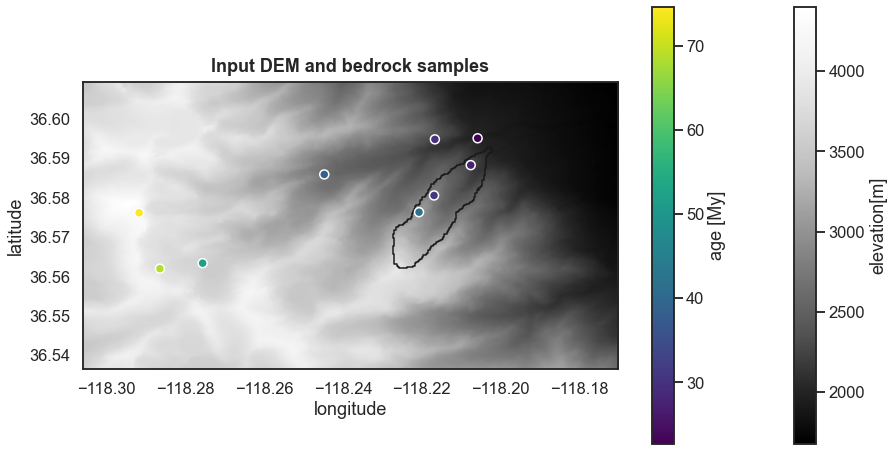

In [4]:
################# Now import age dataset into a pd.DataFrame ##############################
##########################################################################################

if interp_method != 'imp':
    bd = pd.read_excel(ipf+'/'+bedrock_ages_filename)
    bd.sort_values(by='elev',inplace=True)
    z = bd.elev.values
    if z.mean()<10:
        z = z*1000 # convert elevations from km to meters, if that's the case
    a = bd.age.values
    u = bd.sd.values
    lat = bd.lat.values
    lon = bd.lon.values

    # convert from geographic to projected coordinates,
    # otherwise the interpolation will overestimate the role of elevation and produce funny results.
    # preallocate arrays
    x_utm = np.array([])
    y_utm = np.array([])
    for i,v in enumerate(lat):
        xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
        x_utm = np.append(x_utm, xy_utm[0])
        y_utm = np.append(y_utm, xy_utm[1])

    # add points at -5000 m below sample elevation (zero cooling age depth) to arrays
    # such that each x,y location has a double with age=0 and elev=z-5000
    xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
    yy_utm = y_utm
    zz = z
    aa = a
    for i,v in enumerate(z):
        xx_utm = np.append(xx_utm, x_utm[i])
        yy_utm = np.append(yy_utm, y_utm[i])
        zz = np.append(zz, v-5000)
        aa = np.append(aa, 1e-9)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# import watershed outline as geopandas.DataFrame 
ws_outline = gpd.read_file(ipf+'/'+ws_filename)

# make figure, gridspec and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit
if len(e_map_filenames)>0:
    fig = plt.figure(figsize=(15,15*2*dem.nrows/dem.ncols))
    gspec = gs.GridSpec(2,len(e_maps.keys()),figure=fig)
else:
    fig = plt.figure(figsize=(15,15*dem.nrows/dem.ncols))
    gspec = gs.GridSpec(1,1,figure=fig)

# raster plot
ax1 = fig.add_subplot(gspec[0,:]) # first row of plot
im = ax1.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)

ax1.set(aspect='equal', xlabel='longitude', ylabel='latitude',
        xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))

# colorbar
cb1 = fig.colorbar(im)
cb1.set_label('elevation[m]')

# scatter plot if map of bedrock data was not imported
if interp_method != 'imp':
    ax1.set_title('Input DEM and bedrock samples',pad=10, fontdict=dict(weight='bold'))
    sct = ax1.scatter(lon, lat, c=a, cmap='viridis', edgecolor='w')
    cb2 = fig.colorbar(sct)
    cb2.set_label('age [My]')
else:
    ax1.set_title('Input DEM',pad=10, fontdict=dict(weight='bold'))

# plot imported erosional maps, if present
if len(e_map_filenames)>0:
    count = 0
    row2 = []
    for k,i in e_maps.items():
        count+=1
        ax = fig.add_subplot(gspec[1,count-1])
        row2.append(ax)
        im2= ax.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
        em = ax.imshow(i.z, origin='upper', cmap='RdYlBu_r', extent=dem.extent84, alpha=0.5, vmin=0, vmax=max_e)
        ws_outline.plot(edgecolor='k',facecolor='None',ax=ax)
        ax.set_title('Erosion Map: '+k, fontdict=dict(weight='bold'))
        if count == gspec.get_geometry()[1]:
            cb3 = fig.colorbar(em,orientation='horizontal',ax=row2)
            cb3.set_label('erosivity')

# make output directory
if not path.exists(opf):
    mkdir(opf)

# and save figure
fig.savefig(opf+'/input_data.pdf', dpi=200)

if interp_method == 'imp':
    fig = plt.figure(figsize=(15,15))
    gspec = gs.GridSpec(2,1,figure=fig)
    ax1 = fig.add_subplot(gspec[0])
    ax2 = fig.add_subplot(gspec[1])
    im1 = ax1.imshow(age_map.z, extent=dem.extent84, cmap='viridis')
    ax1.set_title('Imported map of bedrock age',pad=10, fontdict=dict(weight='bold'))
    im2 = ax2.imshow(age_map_u.z, extent=dem.extent84)
    ax2.set_title('Imported map of bedrock age error',pad=10, fontdict=dict(weight='bold'))
    # colorbar
    cb1 = fig.colorbar(im1, ax=ax1)
    cb1.set_label('age [My]')
    cb2 = fig.colorbar(im2, ax=ax2)
    cb2.set_label('relative uncertainty [%]')
    
    # and save figure
    fig.savefig(opf+'/input_age_map.pdf', dpi=200)


### Resample DEM and interpolate ages to resampled topographic surface

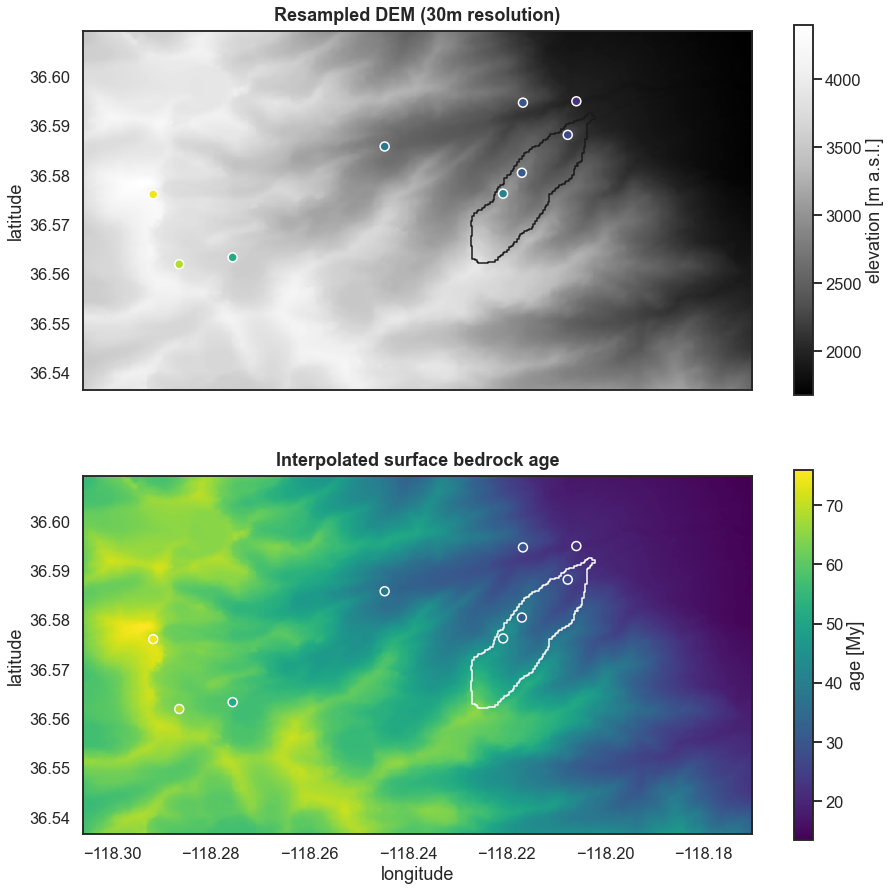

In [5]:
dem.resample(res)
if len(e_map_filenames)>0:
    for k,i in e_maps.items():
        i.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)

########################## Interpolate age data onto the topographic surface #######################
####################################################################################################
# Now run interpolation according to chosen method.

if interp_method =='imp':
    # resample age map
    age_map.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)
    age_interp_map = age_map.zi_res
    # resample age error map
    age_map_u.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)
    age_interp_error_map = age_map_u.zi_res    

elif interp_method == 'rbf':
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(dem.xi_res, dem.yi_res, dem.zi_res)
    
# simple linear regression from age-elevation data
elif interp_method == 'zln':
    reg0 = LinearRegression().fit(z.reshape(-1,1),a.reshape(-1,1))
    intercept0 = reg0.intercept_
    coef0 = reg0.coef_
    R2 = np.round(reg0.score(z.reshape(-1,1),a.reshape(-1,1)), 2)
    if R2 < 0.7:
        print('WARNING!!!')
        print('The scatter of your age-elevation data is rather high (R^2 = '+str(R2)+')')
        print('You might want to use a different interpolation method')
    age_interp_map = intercept0+coef0*dem.zi_res

else:
    # known data points, for which the interpolation function is found
    # they are organized in a 2D array, with columns representing x,y,z
    pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()
    # positions where interpolation needs to be made (all the catchment's gridcells)
    # they are organized in a 2D array, with columns representing x,y,z
    pos = np.concatenate(([dem.xi_res_1d],[dem.yi_res_1d],[dem.zi_res_1d])).transpose()
    age_interp = intr.griddata(points=pts, values=aa, xi=pos)
    if interp_method == 'ext': # call the extrapolation function
        age_interp = extrapolation(age_interp, dem.xi_res_1d, dem.yi_res_1d, dem.zi_res_1d,
                                   a, x_utm, y_utm, z, ext_rad)
    # reshape to 2D    
    age_interp_map = age_interp.reshape(dem.zi_res.shape)
    
#################################### Plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(dem.zi_res, origin='upper', extent=dem.extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')

ax2 = fig.add_subplot(gspec[1])

# plot bedrock surface age map
im2 = ax2.imshow(age_interp_map, origin='upper', extent=dem.extent84, cmap='viridis', alpha=1)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Interpolated surface bedrock age', pad=10, fontdict=dict(weight='bold'))

# plot samples and ages if interpolated map was not imported at the beginning
vmin = min(np.nanmin(age_interp_map),a.min())
vmax = max(np.nanmax(age_interp_map),a.max())
if interp_method != 'imp':
    for ax in [ax1,ax2]:
        ax.scatter(x=lon, y=lat, c=a, cmap='viridis', vmin=vmin, vmax=vmax, edgecolor='w')
        ax.set(xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
        
m = cm.ScalarMappable(cmap='viridis')
m.set_clim(vmin, vmax)
cb = fig.colorbar(m)
cb.set_label('age [My]')

# save fig
fig.savefig(opf+'/DEMres'+str(res)+'_ageinterp.pdf', dpi=200)

### Produce error map

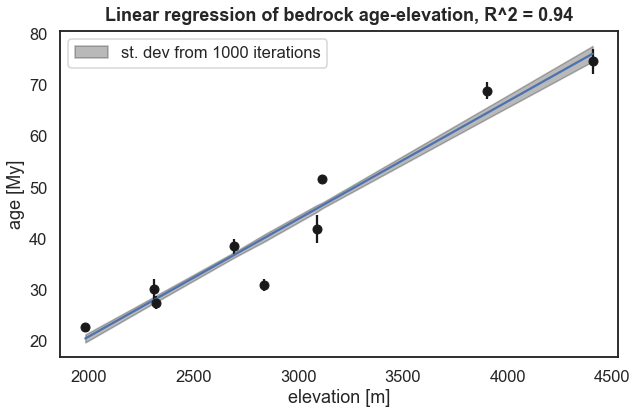

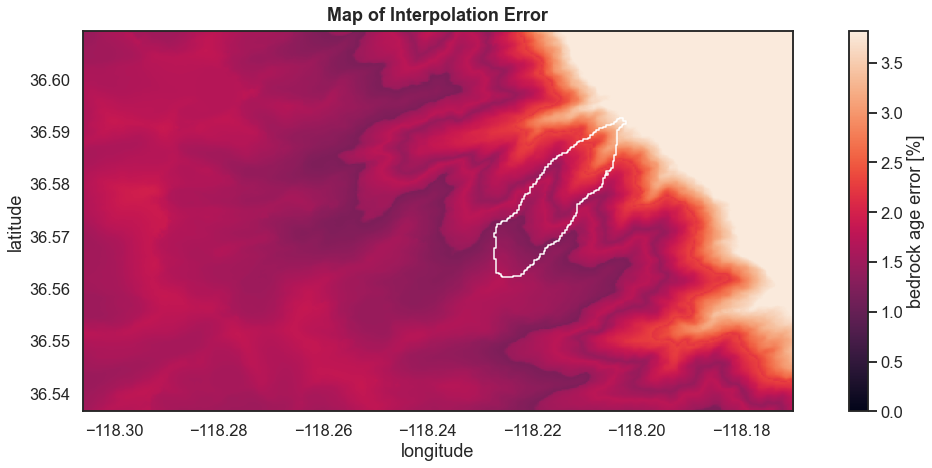

In [6]:
if interp_method != 'imp' and interp_method != 'zln':
    # pre-allocate a vector with as many elements as bedrock samples
    error_interp = np.zeros(lat.size)
    # Bootstrap: for each bedrock sample 1) exclude the related point from input data,
    # 2) calculate an interpolated surface age at its location, 3) save the difference to the known measured age.
    for i in np.arange(lat.size):
        a_boot = np.delete(aa, i)
        x_boot = np.delete(xx_utm, i)
        y_boot = np.delete(yy_utm, i)
        z_boot = np.delete(zz, i)
        # interpolate error with chosen method
        if interp_method == 'rbf':
            rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
            a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
        else:
            pts1 = np.concatenate(([x_boot],[y_boot],[z_boot])).transpose() # data without i sample
            pos1 = np.concatenate(([xx_utm[i]], [yy_utm[i]], [zz[i]])) # coordinates of i sample
            a_int = intr.griddata(points=pts1, values=a_boot, xi=pos1)[0]
        error_interp[i] = abs(aa[i]-a_int)/aa[i]*100

    # calculate sqrt of the square error_interp + square age_sd
    error_total = np.sqrt(error_interp**2+(u/a*100)**2)
    # substitute nans at edge of interpolation with mean error
    error_total[error_total!=error_total] = np.nanmean(error_total)

    # Now make the map by spatially interpolating known error points
    # using chosen interpolation method
    if interp_method == 'rbf':
        rbfi = intr.Rbf(x_utm, y_utm, error_interp, function='linear') # not considering elevation here
        age_interp_error_map = rbfi(dem.xi_res, dem.yi_res) # get interpolated age of excluded sample
    else:
        pts_err = np.concatenate(([x_utm],[y_utm])).transpose()
        age_interp_error = intr.griddata(points=pts_err, values=error_total, xi=dem.res_coords)
        # preallocate array
        age_interp_error_map = np.ones(dem.zi_res.shape)
        for i in np.arange(age_interp_error.size):
            x_ind = int(np.rint((dem.xi_res_1d[i]-dem.xyll[0])/res))
            y_ind = int(np.rint((dem.yi_res_1d[i]-dem.xyll[1])/res))
            # assign nan if out of bounds
            if dem.zi_res[y_ind][x_ind] != dem.zi_res[y_ind][x_ind]:
                age_interp_error_map[y_ind][x_ind] = np.nan
            else:
                age_interp_error_map[y_ind][x_ind] = age_interp_error[i]
        age_interp_error_map = age_interp_error_map[::-1] # flipped to have correct latitude

        if interp_method == 'ext': # call the function
            extra_error = extrapolation(age_interp_error_map.reshape(age_interp_error_map.size),
                                        dem.xi_res_1d, dem.yi_res_1d, dem.zi_res_1d,
                                        error_total, x_utm, y_utm, z, ext_rad)
            age_interp_error_map = extra_error.reshape(dem.zi_res.shape)

elif interp_method == 'zln':
    # for the method 'zln' determine the regression error as a function of elevation only
    # and assign each elevation the corresponding error
    error_interp = np.zeros(z.size)
    for i in np.arange(z.size):
        A_iterations = []
        for j in np.arange(1000):
            A1 = np.array([np.random.normal(AGE,UNC) for AGE,UNC in zip(a,u)])
            reg1 = LinearRegression().fit(z.reshape(-1,1),A1.reshape(-1,1))
            A_iterations.append(reg1.intercept_+reg1.coef_*z[i])
        error_interp[i] = np.std(A_iterations)/a[i]*100
    # total error is the same, because x,y components don't matter in this method
    error_total = error_interp
    # assign the mean error to the entire map?
    age_interp_error = np.interp(dem.zi_res_1d, z, error_total)
    age_interp_error_map = age_interp_error.reshape(dem.zi_res.shape)
    
##################################### Plot the error map ################################
#########################################################################################

if interp_method == 'zln':
    
    if R2 < 0.7:
        print('WARNING!!!')
        print('The scatter of your age-elevation data is rather high (R^2 = '+str(R2)+')')
        print('You might want to use a different interpolation method')
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    a_new = reg0.intercept_+reg0.coef_[0]*z
    ax.fill_between(x=z, y1=a_new-error_interp/100*a_new, y2=a_new+error_interp/100*a_new,color='k',alpha=0.3,
                   label='st. dev from 1000 iterations')
    ax.plot(z, a_new, label='_nolegend_')
    ax.errorbar(z,a,yerr=u,fmt='ok', label='_nolegend_')
    ax.set(xlabel='elevation [m]', ylabel='age [My]')
    ax.set_title('Linear regression of bedrock age-elevation, R^2 = '+str(R2), pad=10, fontdict=dict(weight='bold'))
    ax.legend()
    # save fig
    fig.savefig(opf+'/linear_regression.pdf', dpi=200)
    
# plot error map
fig,ax = plt.subplots(1,1,figsize=(20,7))
vmax = max(np.nanmax(age_interp_error_map),np.nanmax(error_total))
im = ax.imshow(age_interp_error_map, origin='upper', extent=dem.extent84, vmin=0, vmax=vmax)
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude',
       xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
ax.set_title('Map of Interpolation Error', pad=10, fontdict=dict(weight='bold'))

if interp_method == 'imp' or interp_method == 'zln':
    cb = fig.colorbar(im)
    cb.set_label('bedrock age error [%]')
    
else:
    cb = fig.colorbar(im)
    cb.set_label('raster: total error [%]')
    sct = ax.scatter(x=lon, y=lat, c=error_total, edgecolor='w', vmin=0, vmax=vmax)
    cb1 = fig.colorbar(sct)
    cb1.set_label('scatter: interpolation error [%]')

# save fig
fig.savefig(opf+'/age_interp_error_map.pdf', dpi=200)

## Clip to watershed 

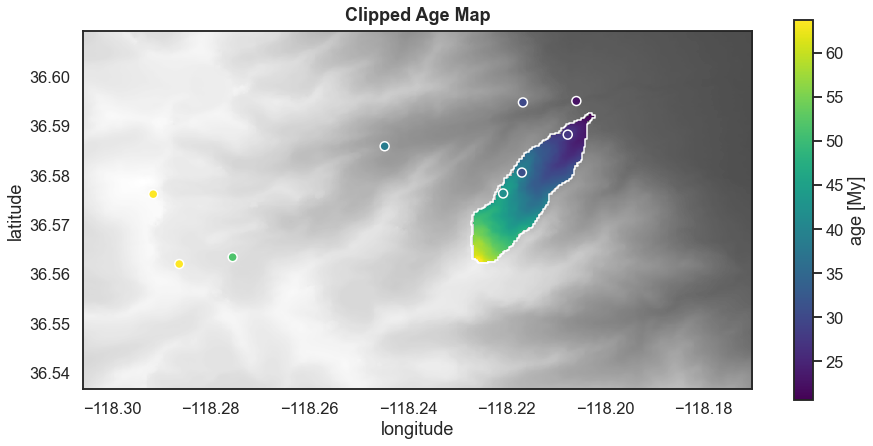

In [7]:
# clip all rasters to watershed
xi_res_clp = clip_to_ws(dem.xi_res, ws_filename, dem.extent84, ipf, opf)
yi_res_clp = clip_to_ws(dem.yi_res, ws_filename, dem.extent84, ipf, opf)
zi_res_clp = clip_to_ws(dem.zi_res, ws_filename, dem.extent84, ipf, opf)

if len(e_map_filenames)>0:
    e_maps_res_clp = dict()
    for k,i in e_maps.items():
        e_maps_res_clp[k] = clip_to_ws(i.zi_res, ws_filename, dem.extent84, ipf, opf)

age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, dem.extent84, ipf, opf)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, dem.extent84, ipf, opf)

# plot the clipped age map
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(dem.zi_res, extent=dem.extent84, origin='upper', cmap='Greys_r', alpha=0.7)
im = ax.imshow(age_interp_map_clp, extent=dem.extent84, origin='upper', cmap='viridis')
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude',
       xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
ax.set_title('Clipped Age Map', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im)
cb.set_label('age [My]')

if interp_method != 'imp':
    ax.scatter(x=lon, y=lat, c=a, edgecolor='w', cmap='viridis',
           vmin=np.nanmin(age_interp_map_clp), vmax=np.nanmax(age_interp_map_clp))

# save fig
fig.savefig(opf+'/clipped_age_map.pdf', dpi=200)

## Make a table of x, y, elev, age, error, erosion

In [8]:
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary

# add labels and grids of the imported erosion maps
if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        labels.append(k)
        grids.append(i)

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    if g[g==g].size != zi_res_clp[zi_res_clp==zi_res_clp].size:
        print('WARNING!!!')
        print('The number of no-data cells in the '+l+' raster must match that of the clipped DEM.')
        print('Please, make sure that the watershed polygon does not contain no-data.')         
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array

if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        ws_data[k] = ws_data[k]/ws_data[k].min() # minimum erosional weight should = 1

ws_data['Euni'] = np.ones(len(ws_data)) # make uniform erosion scenario
        
if example_scenarios:
    # Make example erosional weights (exponential and inverse exponential function of elevation)
    ws_data['E_exp_Z'] = np.exp(ws_data.z/ws_data.z.min())
    ws_data.E_exp_Z = ws_data.E_exp_Z/ws_data.E_exp_Z.min()
    ws_data['E_inv_exp_Z'] = 1/ws_data.E_exp_Z
    ws_data.E_inv_exp_Z = ws_data.E_inv_exp_Z/ws_data.E_inv_exp_Z.min()
    
#     # increasing to the west
#     ws_data['E_exp_X'] = 1/np.exp(300*ws_data.x/ws_data.x.min())
#     ws_data.E_exp_X = ws_data.E_exp_X/ws_data.E_exp_X.min()

#     # Here you can play around with other erosional functions; first define one,
#     # then create the related column like this example:
#     def E_stepwise(z, z_steps, weights):
#         '''
#         example erosional function of z, where prescribed erosional weights are assigned for certain elevation ranges
#         z: elevation at which erosional weight is assigned
#         z_steps: list of elevation thresholds, ascending
#         weights: list of corresponding erosional weights
#         '''
#         if z>z_steps[-1]:
#             print('Warning: also elevations above {} have been assigned {} \
#             as erosional weight'.format(z_steps[-1], weights[-1]))
#             return weights[-1]
#         else:
#             z_steps_a = np.array(z_steps)
#             return weights[z_steps.index(z_steps_a[z<z_steps_a][0])]

#     elevation_steps = [1000,1600,2300]
#     erosional_weights = [5,1,5]
#     ws_data['E_step'] = ws_data.z.apply(lambda z: E_stepwise(z,elevation_steps,erosional_weights))
#     ws_data.E_step = ws_data.E_step/ws_data.E_step.min()

# save to excel and show the first 5 rows of the table
ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)
ws_data.head()

,x,y,z,age,age_u%,Euni,E_exp_Z,E_inv_exp_Z
0,392365.296213,4.050343e+06,1998.0,20.830274,3.758300,1.0,1.005551,2.560265
1,392395.296213,4.050343e+06,1992.0,20.692490,3.787879,1.0,1.002520,2.568008
2,392425.296213,4.050343e+06,1987.0,20.577670,3.812528,1.0,1.000000,2.574478
3,392365.296213,4.050313e+06,2002.0,20.922130,3.738580,1.0,1.007578,2.555116
4,392395.296213,4.050313e+06,1997.0,20.807310,3.763230,1.0,1.005045,2.561554


## Make grain populations for all erosion scenarios and related distributions

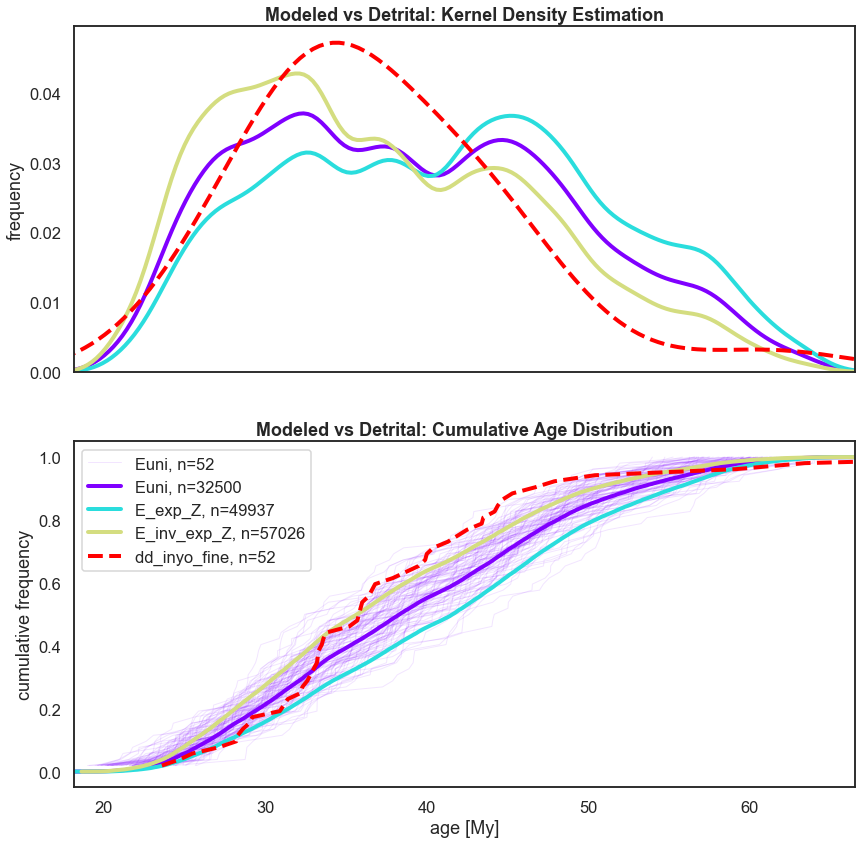

In [9]:
ws_data = pd.read_excel(opf+'/xyz_age_eros.xlsx') # import table of watershed data

# make populations according to the different erosion weighting
multiplier = 10 # starting number of grains for each cell (the more the better, but also slower...)
pops = OrderedDict() # preallocate dictionary of populations
scen_labels = list(ws_data.columns)[5:] # list of scenario labels to iterate through
for s in scen_labels:
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data['N_'+s] = np.rint(ws_data[s]*multiplier) # column that to informs how many grains (N) per cell
    # make a gaussian distribution for each cell
    # Draw from it N grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for A,U,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_'+s]):
        pops[s] = np.append(pops[s], np.random.normal(A,np.abs(A*U/100),int(N)))

############ define reference scenario #########################
ref_scen = 'Euni' 
pops.move_to_end(ref_scen, last=False) # and move it to 1st position in the dictionary

# also load the detrital data and make populations ?
dd = OrderedDict()
detr_labels = []
for file in detrital_ages_filenames:
    detr_label = file[:file.find('.')]
    detr_labels.append(detr_label)
    dd[detr_label] = pd.read_excel(ipf+'/'+file)
    pops[detr_label] = dd[detr_label].age.values

# preallocate dictionary of distributions
dists = OrderedDict()
for label, pop in pops.items():
    dists[label] = make_dists(pop)

##################################### Now Plot distributions #####################################

num_grains = 52 ################################################ specify number of detrital grains

plot_distributions(pops_dict=pops, dists_dict=dists, ref_scen=ref_scen, detr_labels=detr_labels,
                   saveas=opf+'/detrital_distributions.pdf', noise_size=num_grains, show_DKW=False)

# check if something detrital is there
if len(detrital_ages_filenames)<1:
    print('WARNING!!!')
    print('You have not specified any path to the detrital data.')
    print('Please check the input parameters.')

## Confidence in discerning between erosion scenarios and 'Euni'
## as a function of sample size.

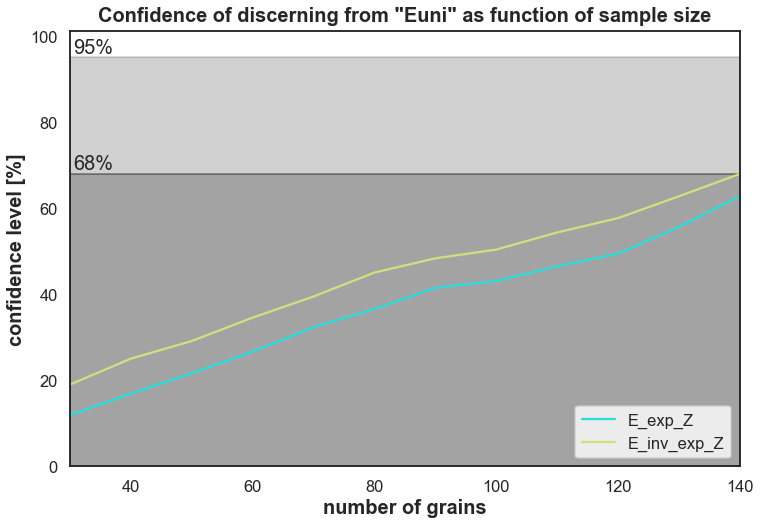

In [10]:
# Assign variables for iterations
all_k = np.arange(30,150,10) # possible N of dated grains (k) to consider
k_iter = 1000 # iterations per k value

# which statistic to be used? [get_KS, 'KS statistic'] or [get_Kui, 'Kuiper statistic']
stat = [get_KS, 'KS statistic']

# calculate 95% confidence divergence for each k, between reference n=∞ and reference n=size of dd
Dc_within = {} # critical divergence between the reference scenario and the subsampled itself
D_dist_dict = {} # store distributions for later confidence plot
Dc = []
for k in all_k:
#     # either use DKW (faster but less exact), calculate DKW epsilon and store it in a list
#     Dc.append(np.sqrt(np.log(2/0.05)/(2*k)))
    
    # or use random sampling
    # get array of random divergencies, using chosen statistic
    D_arr = np.array([stat[0](np.random.choice(pops[ref_scen],k),dists[ref_scen]) for element in np.arange(k_iter)])
    # sort values
    D_arr.sort()
    # calculate cumulative probability of each value
    D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
    D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
    ind95 = np.where(D_arr_prob<=0.95)[0][-1] # index of the 95th percentile
    # store values
    Dc.append(D_arr_vals[ind95])
    D_dist_dict[ref_scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]

Dc_within[ref_scen] = Dc

scen_labels1 = scen_labels.copy()
scen_labels1.pop(scen_labels1.index(ref_scen)) # remove ref_scen from labels for the next plot
for scen in scen_labels1:
    Dc = []
    for k in all_k:
        # get array of random divergences, using chosen statistic
        D_arr = np.array([stat[0](np.random.choice(pops[scen],k),dists[ref_scen]) for element in np.arange(k_iter)])
        # sort values
        D_arr.sort()
        # calculate cumulative probability of each value
        D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
        D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
        D_dist_dict[scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]

################ Calculate the confidence as function of the number of grains ########################
###############################################################################################

# Compare Dc_within to all scenarios for all sample sizes k
# and get the probability of a scenario being discerned from ref_scen for each k
probs = {}
for scen in scen_labels1:
    probs1 = []
    for i in np.arange(len(all_k)): # for all k values
        # get index of element where Dc_within is smaller than Dc_between
        ind = np.where(D_dist_dict[scen+'_'+str(all_k[i])][0]>Dc_within[ref_scen][i])[0][0]
        # get complementary probability at position ind (i.e. what percentage of iterations are greater than that)
        probs1.append(100*(1-D_dist_dict[scen+'_'+str(all_k[i])][1][ind]))
    probs[scen] = probs1

# Plot the confidence as function of grain number
plot_confidence(prob_dict=probs, all_k=all_k, ref_scen=ref_scen,
                saveas=opf+'/scenarios_confidence_sample_size.pdf',num_of_colors=len(dists))

## How do the different scenarios fit to the detrital data?

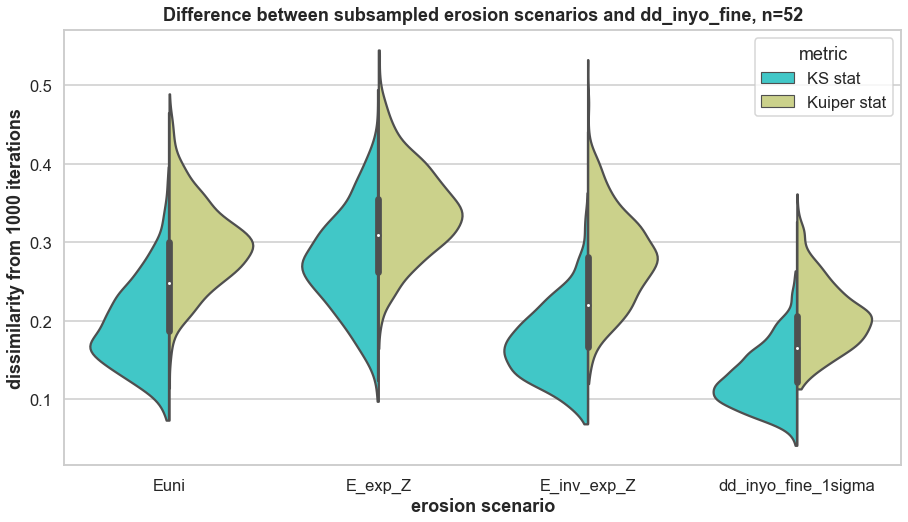

In [11]:
# check if something is there
if len(detrital_ages_filenames)<1:
    print('WARNING!!!')
    print('You have not specified any path to the detrital data.')
    print('Please check the input parameters.')

# allocate dictionary to store all iteration results
iter_results = OrderedDict()
for key,i in dd.items():
    pops.pop(key, None) # remove errorless detrital populations (still to be found as dd['_label_'].age)

# make a detrital population that takes analytical uncertainty into account and see how it compares to scenarios
pops_1sigma = OrderedDict()
for key,i in dd.items():
    # allocate dataframe to store all iteration results
    iter_results[key+'_1sigma'] = pd.DataFrame(columns=['divergence','metric','scenario'])
    KS_list = [] # empty list to receive KS statistic of each iteration
    Kui_list = [] # empty list to receive Kuiper statistic of each iteration
    scenario_list = [] # empty list to receive scenario name of each iteration
    pop_1sigma = np.array([]) # allocate empty array of population
    for j in i.index:
        # for each detrital age, draw 100 normally distributed ages based on analytical error and store them
        pop_1sigma = np.append(pop_1sigma,np.random.normal(i.loc[j].age,i.loc[j].age_u,100))
    # store population in dictionary
    pops_1sigma[key+'_1sigma'] = pop_1sigma
    
    # iterate through erosion scenarios
    for label,pop in pops.items():
        KS_list = KS_list + [get_KS(np.random.choice(pop,len(i)),dists[key]) for element in np.arange(k_iter)]
        Kui_list = Kui_list + [get_Kui(np.random.choice(pop,len(i)),dists[key]) for element in np.arange(k_iter)]
        scenario_list = scenario_list + [label for element in np.arange(k_iter)]
        
    # and do the same analysis for the new pop_1sigma
    KS_list = KS_list + [get_KS(np.random.choice(pop_1sigma,len(i)),dists[key]) for element in np.arange(k_iter)]
    Kui_list = Kui_list + [get_Kui(np.random.choice(pop_1sigma,len(i)),dists[key]) for element in np.arange(k_iter)]
    scenario_list = scenario_list + [key+'_1sigma' for element in np.arange(k_iter)]
    
    # write dataframe
    iter_results[key+'_1sigma'].divergence = KS_list + Kui_list
    iter_results[key+'_1sigma'].metric = ['KS stat' for element in KS_list]+['Kuiper stat' for element in Kui_list]
    iter_results[key+'_1sigma'].scenario = scenario_list + scenario_list
    # make column of div. normalized to mean of each metric
    KS_arr, Kui_arr = np.array(KS_list), np.array(Kui_list)
    iter_results[key+'_1sigma']['divergence_norm'] = np.append((KS_arr-KS_arr.mean())/KS_arr.std(), (Kui_arr-Kui_arr.mean())/Kui_arr.std())
    
    # plot violins to compare
    plot_violins(data=iter_results[key+'_1sigma'], label=key, column='divergence',
                 saveas=opf+'/fit_to_'+key+'_data_violinplot.pdf', k_iter=k_iter, sam_size=len(i))

## Multidimensional Scaling (still to be worked on...?)

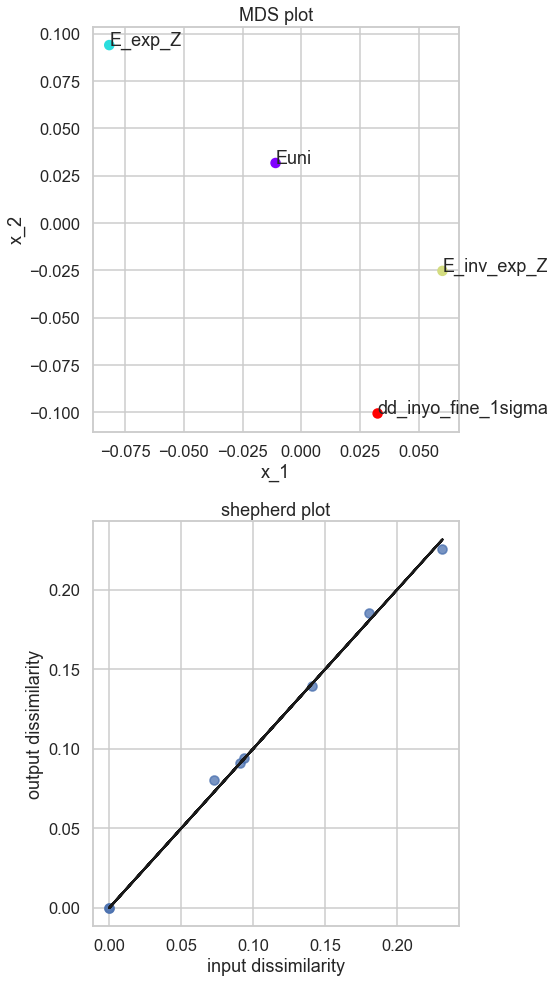

In [12]:
# add back the detrital populations to the dictionary
for k,i in pops_1sigma.items():
    pops[k] = i

l = list(pops.keys())
n = len(l)
diss = np.zeros((n,n))

for i in np.arange(n):
    for j in np.arange(n):
        diss[i,j] = get_KS(pops[l[i]], make_dists(pops[l[j]]))
for i in np.arange(n):
    for j in np.arange(n):
        diss[j,i] = diss[i,j]

from sklearn.manifold import MDS
mmds = MDS(n_components=2, metric=True, dissimilarity='precomputed',eps=1e-3)
x = mmds.fit(diss)

# visualize dissimilarities in a 2D plot
fig,ax = plt.subplots(2,1,figsize=(8,14))
ax[0].scatter(x.embedding_[:,0],x.embedding_[:,1], c=np.arange(n), cmap='rainbow')
for X,Y,l in zip(x.embedding_[:,0],x.embedding_[:,1],l):
    ax[0].annotate(l,(X,Y))
ax[0].set(title='MDS plot', xlabel='x_1', ylabel='x_2')

# calculate distance between points based on MDS results
diss_emb = diss.copy()
for i in np.arange(n):
    for j in np.arange(n):
        diss_emb[i,j] = np.sqrt((x.embedding_[i,0]-x.embedding_[j,0])**2+(x.embedding_[i,1]-x.embedding_[j,1])**2)

# plot input dissimilarities / distances against modeled ones, to see how good the model performs
ax[1].plot(diss.reshape(diss.size), diss.reshape(diss.size),'k')
ax[1].scatter(diss.reshape(diss.size), diss_emb.reshape(diss.size), alpha=0.5)
ax[1].set(title='shepherd plot', xlabel='input dissimilarity', ylabel='output dissimilarity')

plt.tight_layout()

## 3D Plotting example

In [13]:
# from matplotlib.colors import LightSource

# %matplotlib notebook

# # Set up plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,5))

# ls = LightSource(80,20)
# # To use a custom hillshading mode, override the built-in shading and pass
# # in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(dem.z, cmap=cm.gist_earth,vert_exag=0.02,
#                blend_mode='soft',vmin=1700,vmax=4000)
# surf = ax.plot_surface(dem.xi,dem.yi,dem.z,facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=True)
# #ax.set(xticks=[-71.2,-71.1,-71],yticks=[-33,-32.95,-32.9],zticks=[500,1000,1500,2000])
# ax.view_init(50, 30) #50,195